# Figure 2 Recreation (Multi-Log Aggregation)

This notebook aggregates one or more experiment log folders and recreates Figure 2-left (`k_bar` vs `sigma_t`).

It supports both indicators:
- `I_k_current`: current-iteration winner source (`winner_is_global_current` or fallback `winner_is_global`)
- `I_k_best_so_far`: cumulative best-source (`winner_is_global_best_so_far` or fallback)


## Important Definition (Paper-Aligned)
For each local-search iteration `k in {1, ..., K}` at timestep `t`:
- `I_k = I(eps-greedy selects one of the random Normal draws instead of all neighborhood draws at iteration k)`

In this notebook we report two operational versions:
- **Current winner source**: `I_k_current` from `winner_is_global_current`
- **Best-so-far source**: `I_k_best_so_far` from cumulative best global vs local path

And we compute:
- `k_bar = sum_{k=1}^K (k-1) I_k`
- `k_bar/19` for normalized plotting when `K=20`


In [1]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.style.use('seaborn-v0_8-whitegrid')

# Point this to a folder; notebook will recursively aggregate all *.jsonl beneath it.
LOG_ROOT = Path('../logs/search_stats')

# Example:
# LOG_ROOT = Path('../logs/search_stats/fig2left_edm_imagenet_eps_greedy_c5_seed0')

LOG_ROOT


PosixPath('../logs/search_stats')

In [2]:
files = sorted(LOG_ROOT.rglob('*.jsonl'))
if not files:
    raise FileNotFoundError(f'No jsonl files found under {LOG_ROOT}')

rows = []
for fp in files:
    rel_parent = fp.parent.relative_to(LOG_ROOT)
    exp_name = rel_parent.as_posix() if str(rel_parent) != '.' else 'root'
    with fp.open('r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            e = json.loads(line)
            if e.get('event_type') != 'candidate_eval':
                continue
            rows.append({
                'exp_name': exp_name,
                'run_file': fp.name,
                'sample_idx': int(e.get('sample_idx', 0)),
                'class_label_idx': None if e.get('class_label_idx') is None else int(e.get('class_label_idx')),
                'timestep_idx': int(e['timestep_idx']),
                'sigma_t': float(e.get('timestep_value', np.nan)),
                'local_iter_idx': int(e['local_iter_idx']),
                'winner_is_global': bool(e['winner_is_global']),
                'winner_is_global_current': bool(e.get('winner_is_global_current', e['winner_is_global'])),
                'winner_is_global_best_so_far': bool(e.get('winner_is_global_best_so_far', e['winner_is_global'])),
            })

if not rows:
    raise RuntimeError('No candidate_eval rows found in selected JSONL files')

df = pd.DataFrame(rows)
print('jsonl files:', len(files), 'rows:', len(df))
print('exp groups:', sorted(df['exp_name'].unique()))
df.head()


jsonl files: 2 rows: 14400
exp groups: ['fig2left_edm_imagenet_eps_greedy_c5_seed0']


,exp_name,run_file,sample_idx,class_label_idx,timestep_idx,sigma_t,local_iter_idx,winner_is_global,winner_is_global_current,winner_is_global_best_so_far
0,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.0,0,False,False,True
1,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.0,0,False,False,True
2,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.0,0,False,False,True
3,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.0,0,False,False,True
4,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,1,1,0,80.0,0,False,False,True


In [3]:
df['class_label_idx'].value_counts()

class_label_idx
0    1440
1    1440
2    1440
3    1440
4    1440
5    1440
6    1440
7    1440
8    1440
9    1440
Name: count, dtype: int64

In [4]:
# Diagnostic: which class indices are present per run/log
if 'class_label_idx' in df.columns:
    display_df = (
        df.dropna(subset=['class_label_idx'])
          .groupby(['exp_name', 'run_file'])['class_label_idx']
          .unique()
          .reset_index()
    )
    display_df['class_label_idx'] = display_df['class_label_idx'].apply(lambda x: sorted([int(v) for v in x]))
    display_df
else:
    print('class_label_idx not found in logs')


In [5]:
df

,exp_name,run_file,sample_idx,class_label_idx,timestep_idx,sigma_t,local_iter_idx,winner_is_global,winner_is_global_current,winner_is_global_best_so_far
0,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.000,0,False,False,True
1,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.000,0,False,False,True
2,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.000,0,False,False,True
3,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,0,80.000,0,False,False,True
4,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,1,1,0,80.000,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...
14395,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,3,8,17,0.002,19,False,False,True
14396,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,4,9,17,0.002,19,False,False,True
14397,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,4,9,17,0.002,19,False,False,True
14398,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,4,9,17,0.002,19,False,False,True


In [6]:
# One row per local-search iteration event
iter_df = (
    df.groupby(['exp_name', 'run_file', 'sample_idx', 'timestep_idx', 'local_iter_idx'], as_index=False)
      .agg(
          sigma_t=('sigma_t', 'first'),
          I_k_current=('winner_is_global_current', 'first'),
          I_k_best_so_far=('winner_is_global_best_so_far', 'first'),
      )
)
iter_df['k_minus_1'] = iter_df['local_iter_idx'].astype(float)

kbar_df = (
    iter_df.groupby(['exp_name', 'run_file', 'sample_idx', 'timestep_idx'], as_index=False)
          .agg(
              sigma_t=('sigma_t', 'first'),
              k_bar_current=('k_minus_1', lambda s: float((s * iter_df.loc[s.index, 'I_k_current'].astype(float)).sum())),
              k_bar_best_so_far=('k_minus_1', lambda s: float((s * iter_df.loc[s.index, 'I_k_best_so_far'].astype(float)).sum())),
          )
)

# Normalize by 19 as requested
kbar_df['k_bar_current_norm'] = kbar_df['k_bar_current'] / 19.0
kbar_df['k_bar_best_so_far_norm'] = kbar_df['k_bar_best_so_far'] / 19.0
kbar_df.head()


,exp_name,run_file,sample_idx,timestep_idx,sigma_t,k_bar_current,k_bar_best_so_far,k_bar_current_norm,k_bar_best_so_far_norm
0,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,0,80.000000,20.0,190.0,1.052632,10.000000
1,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,1,57.585985,56.0,190.0,2.947368,10.000000
2,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,2,40.785574,11.0,11.0,0.578947,0.578947
3,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,3,28.374585,1.0,3.0,0.052632,0.157895
4,fig2left_edm_imagenet_eps_greedy_c5_seed0,fig2left_edm_imagenet_eps_greedy_c5_seed0_edm_...,0,4,19.352453,33.0,49.0,1.736842,2.578947


In [7]:
kbar_df.shape

(180, 9)

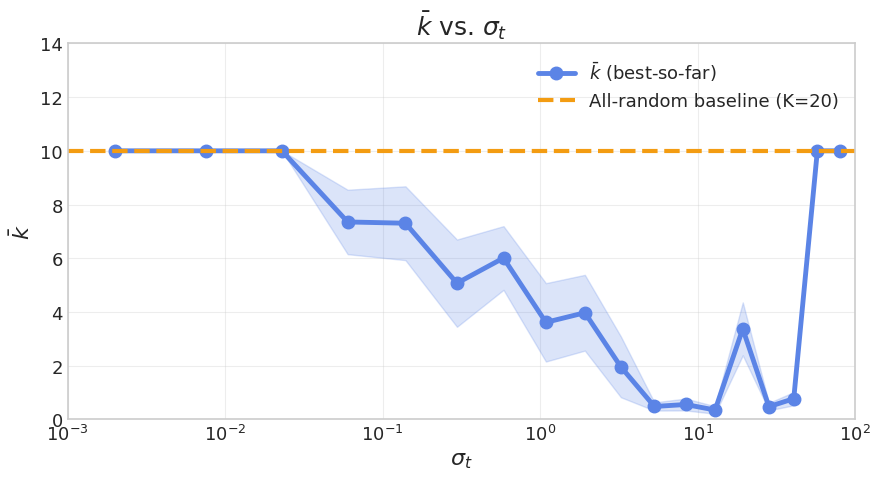

In [9]:
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import numpy as np
import matplotlib as mpl

mpl.rcParams.update({
    "axes.linewidth": 1.2,
    "font.size": 13,
})

# build curve_all from kbar_df
curve_all = (
    kbar_df.groupby('timestep_idx', as_index=False)
           .agg(
               sigma_t=('sigma_t', 'mean'),
               k_bar_best_so_far_mean=('k_bar_best_so_far_norm', 'mean'),
               k_bar_best_so_far_se=('k_bar_best_so_far_norm', 'sem'),
           )
           .sort_values('sigma_t')
)
curve_all['k_bar_best_so_far_se'] = curve_all['k_bar_best_so_far_se'].fillna(0.0)


# --- Compute ±1 SE ---
mean = curve_all['k_bar_best_so_far_mean']
se = curve_all['k_bar_best_so_far_se']
lower = mean - se
upper = mean + se

# Use sigma_t directly (already sorted)
sigma = curve_all['sigma_t'].values

fig, ax = plt.subplots(figsize=(9, 5))

# Main curve
ax.plot(
    sigma,
    mean,
    linewidth=3.5,
    marker='o',
    markersize=9,
    color='#5B84E6',
    label=r'$\bar{k}$ (best-so-far)'
)

# ±1 SE shading
ax.fill_between(
    sigma,
    lower,
    upper,
    alpha=0.22,
    color='#5B84E6'
)

# Baseline
ax.axhline(
    10,
    color='#F39C12',
    linestyle='--',
    linewidth=3,
    label='All-random baseline (K=20)'
)

# Labels
ax.set_title(r'$\bar{k}$ vs. $\sigma_t$', fontsize=18)
ax.set_xlabel(r'$\sigma_t$', fontsize=16)
ax.set_ylabel(r'$\bar{k}$', fontsize=16)

# Log scale
ax.set_xscale('log')

# ---- FIX X AXIS ----
ax.set_xlim(1e-3, 1e2)  # match paper range
ax.xaxis.set_major_locator(LogLocator(base=10.0))
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))

# Clean grid
ax.grid(True, which='major', alpha=0.35)

# Limits
ax.set_ylim(0, 14)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(frameon=False, fontsize=13)

plt.tight_layout()
plt.show()

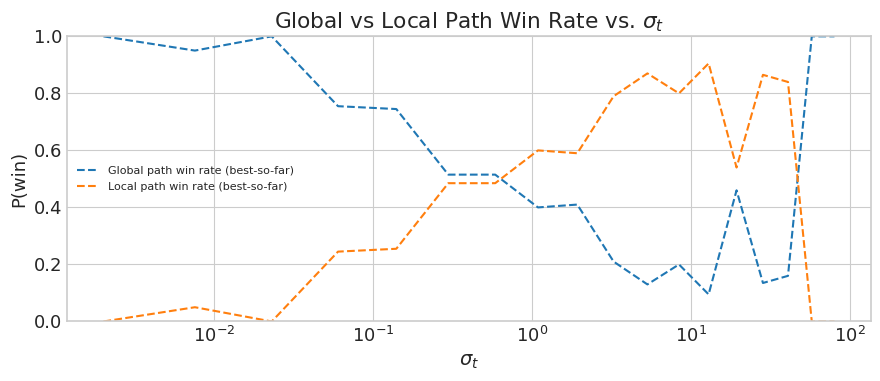

{'global_win_rate_current_pooled': 0.21166666666666667,
 'local_win_rate_current_pooled': 0.7883333333333333,
 'global_win_rate_best_so_far_pooled': 0.5377777777777778,
 'local_win_rate_best_so_far_pooled': 0.4622222222222222}

In [10]:
# CONTINUE HERE
# Global-path vs Local-path win rate by sigma_t
# Uses winner source indicators already logged in candidate_eval.

# Iteration-level frame (one row per run/sample/timestep/local_iter)
iter_win_df = (
    df.groupby(['exp_name', 'run_file', 'sample_idx', 'timestep_idx', 'local_iter_idx'], as_index=False)
      .agg(
          sigma_t=('sigma_t', 'first'),
          winner_is_global_current=('winner_is_global_current', 'first'),
          winner_is_global_best_so_far=('winner_is_global_best_so_far', 'first'),
      )
)

# Current-iteration path win rates
winrate_current = (
    iter_win_df.groupby('timestep_idx', as_index=False)
              .agg(
                  sigma_t=('sigma_t', 'mean'),
                  global_win_rate=('winner_is_global_current', 'mean'),
              )
              .sort_values('sigma_t')
)
winrate_current['local_win_rate'] = 1.0 - winrate_current['global_win_rate']

# Best-so-far path win rates (optional secondary interpretation)
winrate_best_so_far = (
    iter_win_df.groupby('timestep_idx', as_index=False)
              .agg(
                  sigma_t=('sigma_t', 'mean'),
                  global_win_rate_best_so_far=('winner_is_global_best_so_far', 'mean'),
              )
              .sort_values('sigma_t')
)
winrate_best_so_far['local_win_rate_best_so_far'] = 1.0 - winrate_best_so_far['global_win_rate_best_so_far']

fig, ax = plt.subplots(figsize=(9, 4))
# ax.plot(winrate_current['sigma_t'], winrate_current['global_win_rate'], linewidth=2, label='Global path win rate (current)')
# ax.plot(winrate_current['sigma_t'], winrate_current['local_win_rate'], linewidth=2, label='Local path win rate (current)')

# Uncomment if you also want best-so-far interpretation overlaid
ax.plot(winrate_best_so_far['sigma_t'], winrate_best_so_far['global_win_rate_best_so_far'], linewidth=1.5, linestyle='--', label='Global path win rate (best-so-far)')
ax.plot(winrate_best_so_far['sigma_t'], winrate_best_so_far['local_win_rate_best_so_far'], linewidth=1.5, linestyle='--', label='Local path win rate (best-so-far)')

ax.set_title(r'Global vs Local Path Win Rate vs. $\sigma_t$')
ax.set_xlabel(r'$\sigma_t$', fontsize=14)
ax.set_ylabel('P(win)')
ax.set_ylim(0.0, 1.0)
ax.set_xscale('log')
ax.xaxis.set_major_locator(LogLocator(base=10.0))
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Pooled scalar summary
summary = {
    'global_win_rate_current_pooled': float(iter_win_df['winner_is_global_current'].mean()),
    'local_win_rate_current_pooled': float(1.0 - iter_win_df['winner_is_global_current'].mean()),
    'global_win_rate_best_so_far_pooled': float(iter_win_df['winner_is_global_best_so_far'].mean()),
    'local_win_rate_best_so_far_pooled': float(1.0 - iter_win_df['winner_is_global_best_so_far'].mean()),
}
summary


In [25]:
np.ceil((winrate_best_so_far['global_win_rate_best_so_far'] * 0.4 * 20)).sum() + np.ceil((( 1- winrate_best_so_far['global_win_rate_best_so_far']) * 0.6 * 20)).sum()

np.float64(193.0)

In [24]:
np.ceil((winrate_best_so_far['global_win_rate_best_so_far'] * 0.4 * 20).sum())

np.float64(78.0)

In [14]:
20 * 18

360